In [11]:
import gymnasium as gym

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
ENV_NAME = "Pendulum-v1"
env = gym.make(ENV_NAME)

In [3]:
print(env.action_space.shape)
print(env.observation_space.shape)

(1,)
(3,)


In [4]:
def list_to_tensor(l):
  return torch.from_numpy(np.array(l)).to(torch.float32)

In [49]:
class Actor(nn.Module):  # policy
  def __init__(self, action_bound = 2):
    super(Actor, self).__init__()
    self.action_bound = action_bound

    self.layers = nn.ModuleList([])
    self.layers.append(nn.Linear(3, 256))
    self.layers.append(nn.Linear(256, 128))
    self.layers.append(nn.Linear(128, 64))

    self.mu_layer = nn.Linear(64, 1)
    self.std_layer = nn.Linear(64, 1)

  def forward(self, x):
    for layer in self.layers:
      x = F.gelu(layer(x))
    mu = F.tanh(self.mu_layer(x)) * self.action_bound
    std = F.softplus(self.std_layer(x)) + 1e-6
    return mu, std

class Critic(nn.Module):  # approximates V(s_t)
  def __init__(self):
    super(Critic, self).__init__()

    self.layers = nn.ModuleList([])
    self.layers.append(nn.Linear(3, 256))
    self.layers.append(nn.Linear(256, 128))
    self.layers.append(nn.Linear(128, 64))
    self.layer_out = nn.Linear(64, 1)

  def forward(self, x):
    for layer in self.layers:
      x = F.gelu(layer(x))
    return self.layer_out(x)

In [48]:
class A2CAgent():
  def __init__(self,
               discount_factor = 0.99,
               batch_size = 32,
               actor_learning_rate = 0.0001,
               critic_learning_rate = 0.001):

    self.GAMMA = discount_factor
    self.BATCH_SIZE = batch_size
    self.ACTOR_LR = actor_learning_rate
    self.CRITIC_LR = critic_learning_rate

    self.actor = Actor()
    self.critic = Critic()

    self.optim_actor = optim.Adam(self.actor.parameters(), lr = self.ACTOR_LR)
    self.optim_critic = optim.Adam(self.critic.parameters(), lr = self.CRITIC_LR)

    self.buffer = []

  def sample_from_actor(self, mean, std):
    d = Normal(mean, std)
    action = F.tanh(d.sample()) * 2
    log_prob = d.log_prob(action)
    return action, log_prob

  def td_target(self, next_state, reward, dones):
    td_targets = np.zeros(len(next_state))
    for i in range(len(next_state)):
      if dones[i]:
        td_targets[i] = reward[i]
      else:
        v_ = self.critic(list_to_tensor(next_state[i])).detach().numpy().item()
        td_targets[i] = reward[i] + self.GAMMA * v_
    return torch.from_numpy(td_targets).to(torch.float32)

  def flush_buffer(self):
    self.buffer = []

  def unpack_buffer(self):
    states, actions, rewards, next_states, dones = zip(*self.buffer)
    return states, actions, rewards, next_states, dones

In [51]:
agent = A2CAgent(
               discount_factor = 0.9,
               batch_size = 32,
               actor_learning_rate = 7e-3,
               critic_learning_rate = 7e-3)

ENV_NAME = "Pendulum-v1"
env = gym.make(ENV_NAME)

NUM_EPISODES = 1000

pbar = tqdm(range(NUM_EPISODES), desc = "Training process")

critic_losses = []
actor_losses = []
episode_rewards = []

# Train loop
for ep in pbar:
  state, _ = env.reset(seed = 42)
  state = torch.tensor(state, dtype=torch.float32)

  episode_reward = 0
  log_probs = []
  terminated = False
  truncated = False

  agent.actor.train()
  agent.critic.train()
  while not (terminated or truncated):
    mu, std = agent.actor(state)
    action, log_prob = agent.sample_from_actor(mu, std)
    action = action.numpy()
    next_state, reward, terminated, truncated, _ =  env.step(action)

    #Collect samples
    agent.buffer.append((state, action, reward, next_state, (terminated or truncated)))
    log_probs.append(log_prob)

    episode_reward += reward
    #update state
    state = torch.from_numpy(next_state)

    if (len(agent.buffer) >= agent.BATCH_SIZE) or terminated or truncated:
      log_probs = torch.stack(log_probs)  # torch.stack을 써야 배치로 역전파 가능함.. torch.tensor로 묶으면 안됨!!!!

      states, actions, rewards, next_states, dones = agent.unpack_buffer()
      with torch.no_grad():
        td_targets = agent.td_target(next_states, rewards, dones)
      v = agent.critic(list_to_tensor(states))

      # mse loss (for Critic Loss)
      critic_loss = F.mse_loss(v, td_targets.unsqueeze(1), reduction="mean")
      # actor loss
      actor_loss = (-1) * (log_probs *(td_targets - v.detach())).mean()

      agent.optim_critic.zero_grad()
      agent.optim_actor.zero_grad()

      critic_loss.backward()
      actor_loss.backward()

      agent.optim_critic.step()
      agent.optim_actor.step()

      agent.flush_buffer()
      log_probs = []

  pbar.set_postfix({"Episode" : ep+1, "Critic Loss" : critic_loss.item(), "Actor Loss" : actor_loss.item(), "Episode Reward" : episode_reward})
  pbar.update(1)

  actor_losses.append(actor_loss.item())
  critic_losses.append(critic_loss.item())
  episode_rewards.append(episode_reward)

Training process: 100%|██████████| 1000/1000 [05:55<00:00,  2.81it/s, Episode=1000, Critic Loss=556, Actor Loss=18.3, Episode Reward=-1.66e+3]


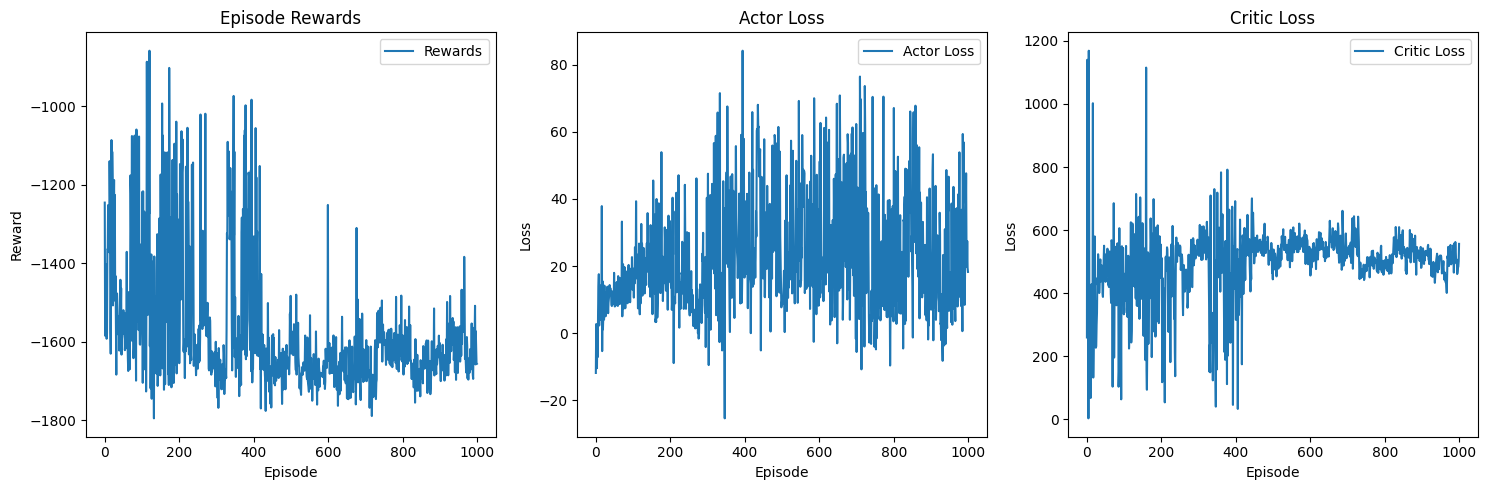

In [52]:
# 그래프 그리기
plt.figure(figsize=(15, 5))

# 에피소드별 보상
plt.subplot(1, 3, 1)
plt.plot(episode_rewards, label='Rewards')
plt.title("Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()

# 에피소드별 배우(Actor) 손실
plt.subplot(1, 3, 2)
plt.plot(actor_losses, label='Actor Loss')
plt.title("Actor Loss")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()

# 에피소드별 평가자(Critic) 손실
plt.subplot(1, 3, 3)
plt.plot(critic_losses, label='Critic Loss')
plt.title("Critic Loss")
plt.xlabel("Episode")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [53]:
# Evaluate

from gymnasium.wrappers import RecordVideo
from IPython.display import Video

def evaluate(agent, num_episodes = 5, seed = 42):
    with torch.no_grad():
        agent.actor.eval()
        agent.critic.eval()

        video_folder = "./videos/"
        os.makedirs(video_folder, exist_ok=True)
        env = RecordVideo(gym.make(ENV_NAME, render_mode="rgb_array"), video_folder=video_folder, episode_trigger=lambda x: True)

        for ep in range(num_episodes):
            state, _ = env.reset(seed = seed)
            state = torch.from_numpy(state)
            terminated  = False
            truncated = False
            total_reward = 0

            while not (terminated or truncated):
                mu, sigma = agent.actor(state)
                action, _ = agent.sample_from_actor(mu, sigma)
                action = action.numpy()
                next_state, reward, terminated, truncated, _ =  env.step(action)

                next_state = state

        env.close()

        video_path = os.path.join(video_folder, os.listdir(video_folder)[0])
        return video_path

# 모델 추론 실행
if __name__ == "__main__":
    video_path = evaluate(agent, num_episodes=5, seed = 42)

/usr/local/lib/python3.11/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
